# Dataset Setup

authors: Bolzonello Enrico, Carlesso Daniel, Zadro Michele

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import constants

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')

## Padova Graph

First we need the Padua street network, which we get from OpenStreetMap thanks to the Python library OSMnx

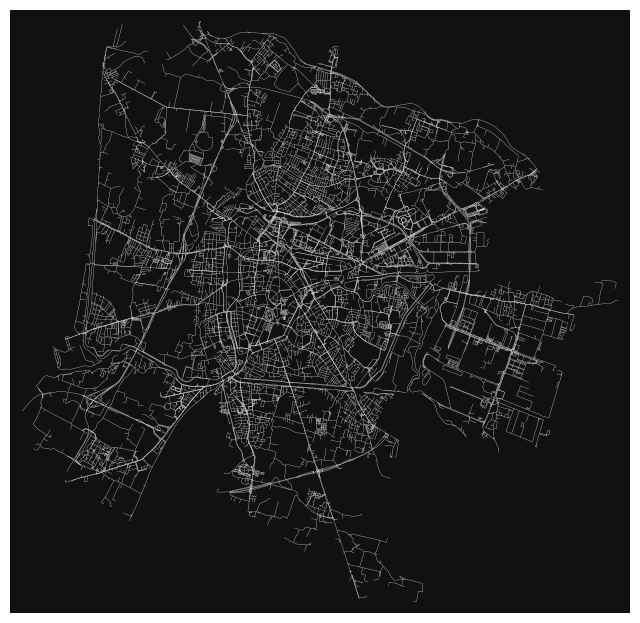

In [3]:
G_padova = ox.graph_from_place(constants.PLACE_NAME, network_type="walk", simplify=True)
G_padova = ox.get_undirected(G_padova)
fig, ax = ox.plot_graph(G_padova, node_size=0, edge_color="w", node_color="r", edge_linewidth=0.2)

In [4]:
print(f"number of nodes before simplification: {len(G_padova)}")

number of nodes before simplification: 20360


The number of nodes for the Padua street network is too large, since complex interchanges and roundabouts form clusters of nodes where the real connection is essentialy only one. So the next step is to simplify the street network, assuming nodes at maximum 15 meters are the same intersection

In [5]:
G_proj = ox.project_graph(G_padova)
G_padova_simplified = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
print(f"number of nodes after simplification: {len(G_padova_simplified)}")

number of nodes after simplification: 5462


### Consolidation example

To make clear what's happening, let's make an example to see it visually.
This is the graph before simplification:

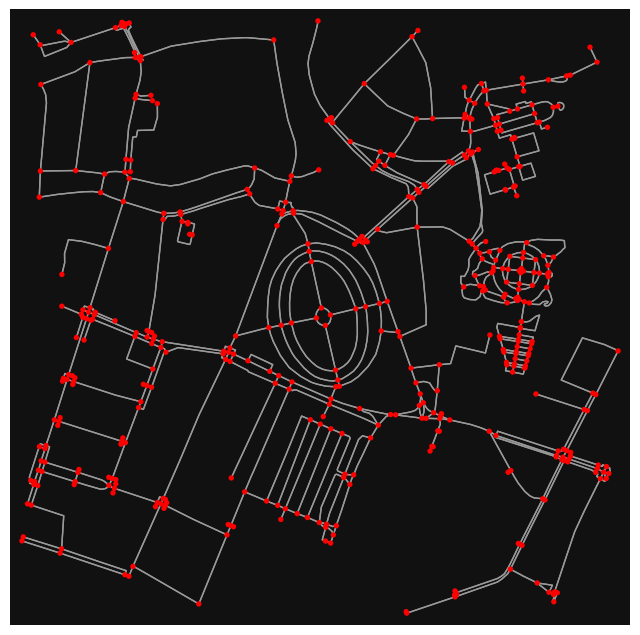

In [6]:
point = 45.39840,11.87644
G_ex = ox.graph_from_point(point, network_type="walk", dist=500)
fig, ax = ox.plot_graph(G_ex, node_color="r")

It is interesting to observe that complex intersections are represented by multiple nodes, which is not what we need.
After consolidating the intersections, the graph becomes:

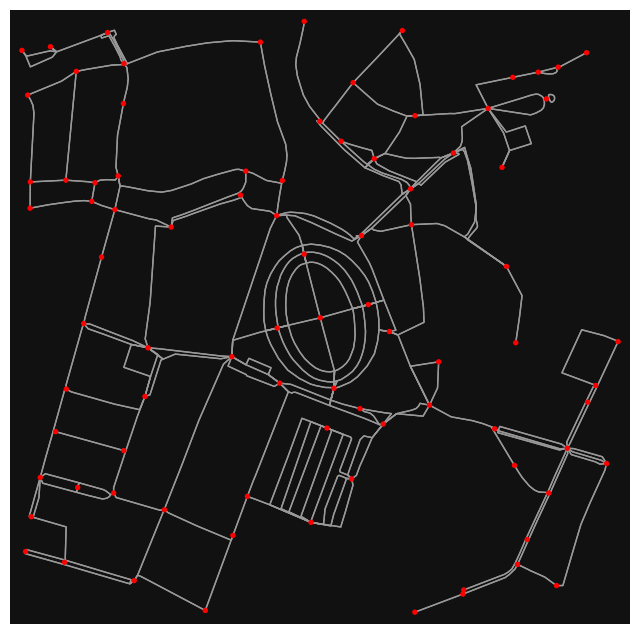

In [7]:
G_proj_ex = ox.project_graph(G_ex)
G_ex_simple = ox.consolidate_intersections(G_proj_ex, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(G_ex_simple, node_color="r")

which conforms much better to modeling.
The drawback is an over-simplification of some connections, like the section at east of Prato della Valle, which is actually the Botanic garden, so simplifying to few nodes is not actually a big deal.
Another example is in the South, where there are a few close parallel connections, but it turns out to be a parking spot, so it is no big deal to over-simplify it.

In [8]:
ox.save_graph_shapefile(G_padova_simplified, filepath='data/graph/', encoding='utf-8')

Just to see that everything worked, let's print some data from the GeoDataframes

In [9]:
nodes_gdf = gpd.read_file('data/graph/nodes.shp')
edges_gdf = gpd.read_file('data/graph/edges.shp')

Be sure that the CRS (Coordinate Reference Systems) is the same between the GDFs and the graph

In [10]:
assert nodes_gdf.crs == edges_gdf.crs == G_padova_simplified.graph['crs']

In [11]:
nodes_gdf.head()

,osmid,osmid_orig,x,y,street_cou,lon,lat,highway,ref,geometry
0,0,"[141540485, 254672751, 197522982, 254672878, 2...",724701.900173,5.034203e+06,0,NaN,NaN,None,None,POINT (724701.900 5034203.206)
1,1,"[141542464, 522060005, 10964558191, 1855945754...",725125.264890,5.032994e+06,0,NaN,NaN,None,None,POINT (725125.265 5032993.789)
2,2,"[522060014, 206354760, 5392711449, 5392711456,...",725269.805793,5.032962e+06,0,NaN,NaN,None,None,POINT (725269.806 5032962.359)
3,3,"[141542473, 5792497355, 7086991412, 5798251594...",726160.105869,5.032901e+06,0,NaN,NaN,None,None,POINT (726160.106 5032900.781)
4,4,"[1113558376, 1101896841, 1101896807]",725349.659264,5.032934e+06,0,NaN,NaN,None,None,POINT (725349.659 5032934.463)


In [12]:
edges_gdf.head()

,u,v,key,osmid,highway,oneway,reversed,length,from,to,...,maxspeed,bridge,access,service,area,junction,tunnel,est_width,ref,geometry
0,0,235,0,244968982,path,0,False,262.005714,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724666.149..."
1,0,235,1,41224006,tertiary,0,False,205.686533,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724674.181..."
2,0,235,2,"[23516585, 960693916]","['footway', 'residential']",0,"[False, True]",269.826579,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724686.435..."
3,0,235,3,244969034,path,0,True,219.053507,0,235,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724701.900 5034203.206, 724678.669..."
4,0,233,0,244969016,path,0,False,269.193872,233,0,...,None,None,None,None,None,None,None,None,None,"LINESTRING (724714.668 5034196.773, 724771.919..."


In [22]:
len(edges_gdf)

10496

In [13]:
default_crs = str(G_padova_simplified.graph["crs"])
default_crs

'EPSG:32632'

## Points of Interest (POIs)
Let's define the POIs we are interested in, the full table can be found in the presentation paper.

In [14]:
# just for easy scalability
buildings_names = {z[0]: z[1] for z in zip(constants.CATEGORIES, constants.VALUES)}

For each group, let's create a GeoDataFrame and save it in another dictionary for easy access.

In [15]:
buildings_gdf = dict.fromkeys(constants.CATEGORIES)
for category in constants.CATEGORIES:
    # set the key (based on OSM specification)
    poi_key = "amenity"
    if category == "transp":
        poi_key = "public_transport"
    if category == "food":
        poi_key = "shop"

    # set the value (simply the array)
    poi_value = buildings_names[category]

    # create the GeoDataFrame
    buildings_gdf[category] = ox.features_from_place(
            PLACE_NAME,
            {poi_key: poi_value}
        )

    # convert to the same crs as the graph
    buildings_gdf[category] = ox.project_gdf(buildings_gdf[category], to_crs=default_crs)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/releas

In [16]:
for category in constants.CATEGORIES:
    # create lon and lat columns
    buildings_gdf[category]['geometry'] = buildings_gdf[category]['geometry'].apply(lambda p: p.centroid if p.geom_type == 'Polygon' or p.geom_type == 'LineString' else p)
    buildings_gdf[category]['lon'] = buildings_gdf[category]['geometry'].apply(lambda p: p.x)
    buildings_gdf[category]['lat'] = buildings_gdf[category]['geometry'].apply(lambda p: p.y)
    # create type column
    buildings_gdf[category]['type'] = category
    
    #select only lon, lat and geometry columns
    buildings_gdf[category] = buildings_gdf[category][['lon', 'lat', 'geometry','type']]
    
    # save to file
    buildings_gdf[category].to_file(f"./data/pois/{category}.gpkg", driver="GPKG")

In [17]:
buildings_gdf['food']

lon           lat  \
element_type osmid                                     
node         256072065   723632.474313  5.032541e+06   
             296955042   724512.659878  5.035389e+06   
             296955316   724582.276921  5.036786e+06   
             296963264   725772.089879  5.035923e+06   
             334511575   727563.487773  5.032837e+06   
...                                ...           ...   
way          723610182   727068.059942  5.033121e+06   
             775415671   723966.151299  5.029476e+06   
             777319580   726447.189776  5.034391e+06   
             827115934   726876.976012  5.034175e+06   
             1204651301  724496.016204  5.033601e+06   

                                               geometry  type  
element_type osmid                                             
node         256072065   POINT (723632.474 5032541.232)  food  
             296955042   POINT (724512.660 5035388.753)  food  
             296955316   POINT (724582.277 5036785.715)  food  
             296963264   POINT (725772.090 5035923.059)  food  
             334511575   POINT (727563.488 5032836.529)  food  
...                                                 ...   ...  
way          723610182   POINT (727068.060 5033120.711)  food  
             775415671   POINT (723966.151 5029476.231)  food  
             777319580   POINT (726447.190 5034390.961)  food  
             827115934   POINT (726876.976 5034174.600)  food  
             1204651301  POINT (724496.016 5033601.249)  food  

[129 rows x 4 columns]

For each POI, find the closest node in the Padua graph and mark it as POI.
First, add a POI column with default value None

In [18]:
nodes_gdf['POI'] = None

In [19]:
for category in constants.CATEGORIES:
    X_list = buildings_gdf[category]['lon'].values.tolist()
    Y_list = buildings_gdf[category]['lat'].values.tolist()

    nearest_nodes = ox.nearest_nodes(G_padova_simplified, X_list, Y_list,)

    for n in nearest_nodes:
        nodes_gdf.at[n, 'POI'] = category
    print(f"category: {category}\t # nodes: {len(nodes_gdf[nodes_gdf['POI'] == category])}")

category: edu	 # nodes: 114
category: health	 # nodes: 92
category: transp	 # nodes: 484
category: food	 # nodes: 120


In [20]:
nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf = edges_gdf.set_index(['u', 'v', 'key']) 

G = ox.utils_graph.graph_from_gdfs(nodes_gdf, edges_gdf)

In [21]:
ox.save_graph_shapefile(G, filepath='data/graph/', encoding='utf-8')

/var/folders/wv/ytkybb0n2xl85tdnn00rf_9c0000gn/T/ipykernel_4635/4258711556.py:1: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  ox.save_graph_shapefile(G, filepath='data/graph/', encoding='utf-8')
